# Wine Data Clustering

## Section 1: k-Means Clustering

k-Means is a **partition-based clustering algorithm** that groups data points into a predefined number of **k clusters** based on similarity. Each cluster is represented by a **centroid**, and the goal is to minimize the distance between data points and their respective centroids.


### Step 1: Load the data

In [27]:
# Importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [28]:
# Importing data and transforming using PCA
data = pd.read_csv("winequality-red.csv")

# View the data
data.head()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Step 2: Data Pre-processing

### 2.1 Check Summary Stats

In [29]:
# Check the summary stats
data.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### 2.2 Remove outliers

In [30]:
# Function to detect outliers using the IQR method
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25, method='midpoint')
    Q3 = np.percentile(data, 75, method='midpoint')
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Detecting and removing outliers for all features except 'quality'
outliers_removed = data.copy()  # Make a copy of the original data

for column in outliers_removed.columns:
    if column != 'quality':  # Skip the target column
        lower_bound, upper_bound = detect_outliers_iqr(outliers_removed[column])
        # Remove rows with outliers
        outliers_removed = outliers_removed[
            (outliers_removed[column] >= lower_bound) &
            (outliers_removed[column] <= upper_bound)
        ]

# Check the size of the original and cleaned data
original_size = data.shape[0]
cleaned_size = outliers_removed.shape[0]

print(f"Original size: {original_size}, Cleaned size: {cleaned_size}")



Original size: 1599, Cleaned size: 1134


### 2.2 Perform Scaling

In [6]:
# Import required libraries
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = outliers_removed.drop('quality', axis=1)

# Scale the data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data after scaling:\n", X_scaled[:5])


Data after scaling:
 [[-0.52003789  1.07998484 -1.36639491 -0.64024686 -0.16976355 -0.44124129
  -0.28087575  0.78989451  1.42261701 -0.61003152 -1.00054733]
 [-0.24248855  2.17306283 -1.36639491  0.95444394  1.4357183   1.18899998
   1.06117384  0.14620865 -0.96225082  0.46443249 -0.5797655 ]
 [-0.24248855  1.44434417 -1.14441263  0.27100503  0.99785961  0.02454193
   0.53248764  0.27494582 -0.5006635   0.19581649 -0.5797655 ]
 [ 2.11668088 -1.47053049  1.74135704 -0.64024686 -0.24274     0.25743354
   0.77649665  0.91863169 -1.2699757  -0.43095419 -0.5797655 ]
 [-0.52003789  1.07998484 -1.36639491 -0.64024686 -0.16976355 -0.44124129
  -0.28087575  0.78989451  1.42261701 -0.61003152 -1.00054733]]


### 2.3 Reduce Dimensions using PCA

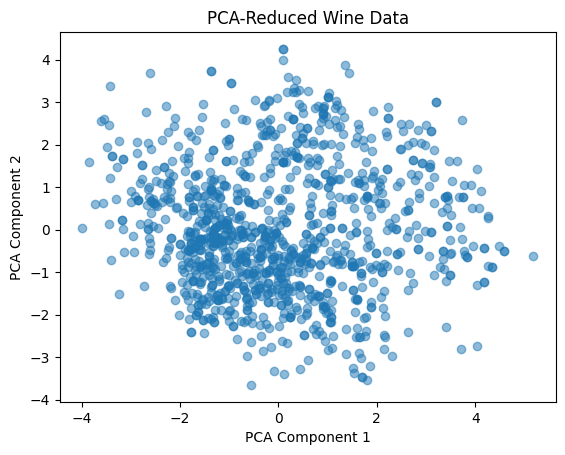

In [7]:
# Import required modules
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce the dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the PCA-transformed data
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title("PCA-Reduced Wine Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


### Step 3: Apply Clustering

In [8]:
# Import libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [9]:
# k-means with some arbitrary k (number of clusters)
kmeans = KMeans(n_clusters=5, max_iter=1000, random_state=123)
kmeans.fit(X_pca)

KMeans(max_iter=1000, n_clusters=5, random_state=123)

In [10]:
# Print k-means labels
kmeans.labels_

array([0, 0, 0, ..., 2, 2, 4], dtype=int32)

### 3.1 Find the Optimal Number of Clusters
- Elbow Method
- Silhoutte Analysis


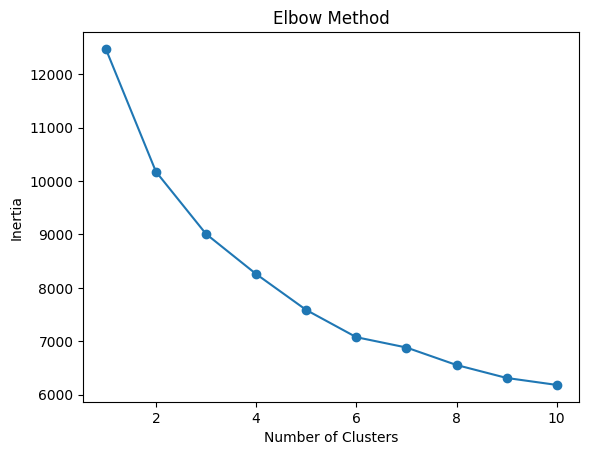

In [11]:
# Elbow-curve/SSD Method
# Using the Elbow Method to find the optimal number of clusters
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


### Interpretation:
- From the elbow method we can say that k = 3 clusters seems to be a good choice

In [12]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for num_clusters in range_n_clusters:

    # Intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(X_pca)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.3809357162655726
For n_clusters=3, the silhouette score is 0.3694346275722262
For n_clusters=4, the silhouette score is 0.36615617903488923
For n_clusters=5, the silhouette score is 0.3590801998657661
For n_clusters=6, the silhouette score is 0.35330183724913256
For n_clusters=7, the silhouette score is 0.3533083898737944
For n_clusters=8, the silhouette score is 0.3524232109104793
For n_clusters=9, the silhouette score is 0.34533397934978044
For n_clusters=10, the silhouette score is 0.3511447758710206


### Interpretation:
- Silhoutte scores also suggest k=3 as the ideal value.

### 3.2 Build the final model with optimal 'k' value

In [13]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=1000, random_state=123)
kmeans.fit(X_pca)

KMeans(max_iter=1000, n_clusters=3, random_state=123)

In [14]:
X_pca_df = pd.DataFrame(X_pca,columns=['PC1','PC2'])
X_pca_df['K_Means_Cluster_ID'] = kmeans.labels_
X_pca_df

,PC1,PC2,K_Means_Cluster_ID
0,-1.726817,-1.210509,0
1,-0.563987,-2.646924,0
2,-0.527001,-1.715152,0
3,2.977670,-0.038400,1
4,-1.726817,-1.210509,0
...,...,...,...
1129,-2.290933,-0.659487,2
1130,-2.515793,0.576244,2
1131,-1.433670,0.398537,2
1132,-2.600920,-0.312332,2


In [15]:
# Checking a few values
X_pca_df['K_Means_Cluster_ID'][0:10]

,K_Means_Cluster_ID
0,0
1,0
2,0
3,1
4,0
5,0
6,0
7,2
8,2
9,0


<Axes: xlabel='PC1', ylabel='PC2'>

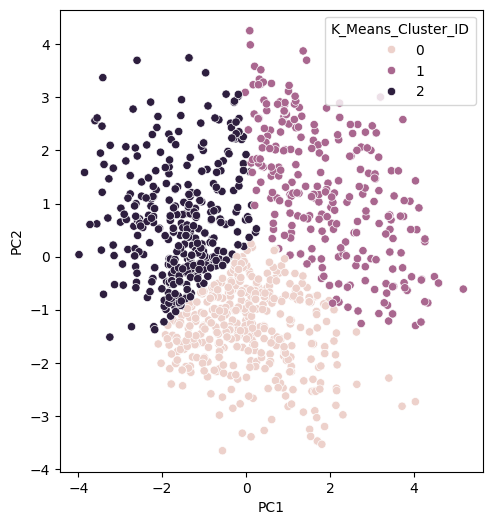

In [16]:
# Scatter plot of the two principal components to observe the cluster distribution

plt.figure(figsize=(12,6),dpi=100)

plt.subplot(1,2,1)
sns.scatterplot(x='PC1',y='PC2',data=X_pca_df,hue='K_Means_Cluster_ID')

### Interpretation:
- The clusters are fairly well-separated along the two principal components (PC1 and PC2).
- The clusters are roughly spherical, which aligns with how K-Means works (it prefers compact clusters with similar spread).
- Some overlap between clusters is visible, especially between Cluster 0 and Cluster 1. This indicates some similarity in these regions or potential noise in the data.
- The clusters seem to have a similar number of data points, suggesting that K-Means found relatively balanced clusters.
<hr> <hr>

## Section 2: Hierarchical Clustering


Hierarchical clustering is an **unsupervised learning algorithm** that builds a hierarchy of clusters, represented using a **dendrogram** (tree-like structure).


In [17]:
# Import libraries
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import silhouette_score

### Do hierarchical clustering via complete linkage

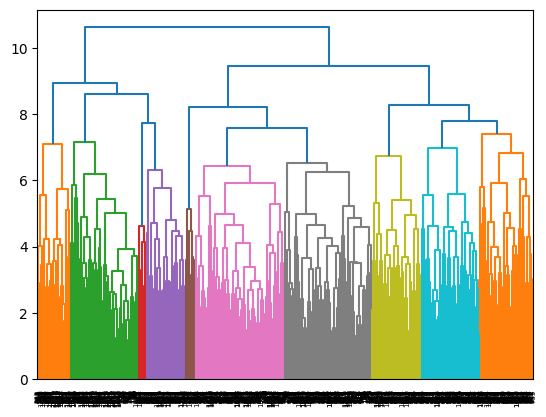

In [18]:
# complete linkage
# Generate the hierarchical clustering linkage matrix using 'complete' linkage method
cl_mergings = linkage(X_scaled, method="complete", metric='euclidean')


# Plot the dendrogram to visualize the hierarchical clustering
dendrogram(cl_mergings)


# Display the plot
plt.show()


In [20]:
# Create complete linkage cluster labels choosing number of clusters to be 3
cl_cluster_labels = cut_tree(cl_mergings, n_clusters=3).reshape(-1, )

### Plot the hierarchical clustering graph

<Axes: xlabel='PC1', ylabel='PC2'>

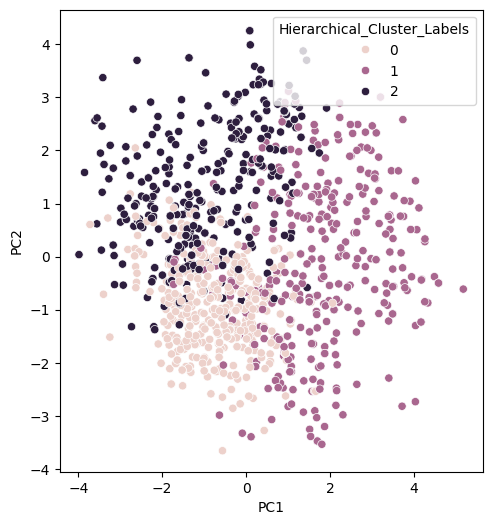

In [21]:
X_pca_df = pd.DataFrame(X_pca,columns=['PC1','PC2'])
X_pca_df['Hierarchical_Cluster_Labels'] = cl_cluster_labels

# Plot the clusters
plt.figure(figsize=(12,6),dpi=100)
plt.subplot(1,2,2)
sns.scatterplot(x='PC1',y='PC2',data=X_pca_df,hue='Hierarchical_Cluster_Labels')

### Interpretation:
- The clusters here seem more elongated and less compact compared to K-Means clustering. Hierarchical clustering often identifies less defined boundaries since it merges points based on linkage criteria.
- There is visible overlap between clusters, especially around the center, which suggests:
  - Either the clusters are not well-separated in this PCA-reduced space.
  - Or some points lie close to the boundary between multiple clusters.
- The clusters are not as spherical or balanced in shape compared to K-Means. This reflects how hierarchical clustering does not assume cluster shapes.

<hr> <hr>

## Section 3: Density based Clustering


Density-based clustering identifies clusters as dense regions of data points separated by areas of low density. It works well with arbitrary-shaped clusters and can detect outliers effectively.


In [22]:
# Import libraries
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [23]:
# DBSCAN model
# Initialize the DBSCAN clustering model
dbscan = DBSCAN(eps=0.5, min_samples=4)

dbscan.fit(X_pca)

DBSCAN(min_samples=4)

In [24]:
# Print DBSCAN labels
# Noisy samples are given the label -1
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
# Print silhouette score
silhouette_avg = silhouette_score(X_pca, dbscan.labels_)
print(silhouette_avg)

0.2148653382312363


### Interpretation:
-

Let's check the visualization and confirm this.

<Axes: xlabel='PC1', ylabel='PC2'>

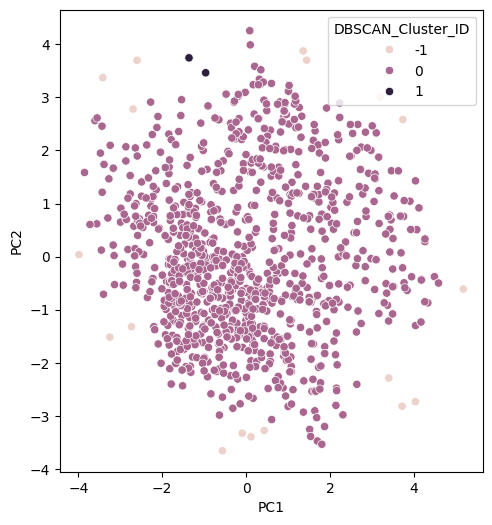

In [26]:
# Assign cluster labels to each row in a new column DBSCAN_Cluster_ID
X_pca_final_df = pd.DataFrame(X_pca,columns=['PC1','PC2'])
X_pca_final_df['DBSCAN_Cluster_ID'] = dbscan.labels_

# scatter plot using the first two principal components to observe the cluster distribution
plt.figure(figsize=(12,6),dpi=100)
plt.subplot(1,2,1)
sns.scatterplot(x='PC1',y='PC2',data=X_pca_final_df,hue='DBSCAN_Cluster_ID')

### Interpretation:
- Points labeled -1 are identified as noise/outliers by DBSCAN. These are data points that do not belong to any cluster based on the minimum number of neighbors within the specified distance (`eps`).
- A few outlier points are scattered around the edges, indicating that DBSCAN has successfully filtered out some noise.
- DBSCAN is good at identifying arbitrary shaped clusters, but here the main cluster (cluster 0) forms a dense core with scattered outliers. This suggests that most points are densely packed into a single region.
- There is a small, separate cluster (Cluster 1) with very few points. This could indicate localized groups or patterns distinct from the main body of data.
- Most of the data falls into one central cluster (Cluster 0), suggesting that the dataset has a high density in the center. DBSCAN may not always create multiple clusters if the data is mostly uniform in density.

*Note:If the data distribution is mostly dense in the center with little variation (as observed here), DBSCAN may place most points into a single cluster, limiting its effectiveness for clustering.*
<hr><hr>